# Comparison of $L^2_\mu$ and $H^1_\mu$ Neural Operator Inverse Solutions

In [1]:
# MIT License
# Copyright (c) 2025
#
# This is part of the dino_tutorial package
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND.
# For additional questions contact Thomas O'Leary-Roseberry

import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_PATH', "../") )
from hippylib import *

# from misfits import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

from linear_elasticity_model import *

from plotting_utils import *

In [2]:
settings = linear_elasticity_settings()
model = linear_elasticity_model(settings)

Vh = model.problem.Vh

Number of dofs: STATE=3322, PARAMETER=1661, ADJOINT=3322
Number of observation points: 50


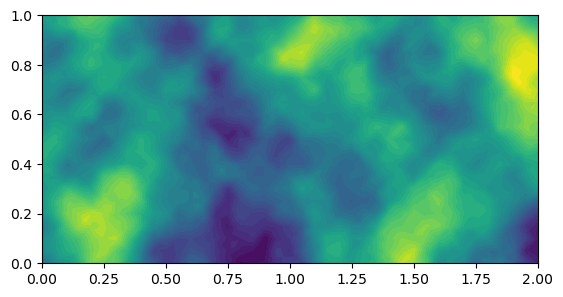

In [3]:
m_true = true_parameter(model.prior)
m_true_func = dl.Function(model.problem.Vh[hp.PARAMETER])
# m_true_func.vector().zero()
# m_true_func.vector().axpy(1.,m_true)

noise = dl.Vector()
model.prior.init_vector(noise,"noise")
hp.parRandom.normal(1., noise)
mtrue = dl.Vector()
model.prior.init_vector(mtrue, 0)
model.prior.sample(noise, mtrue)
m_true_func.vector().zero()
m_true_func.vector().axpy(1.,mtrue)

dl.plot(m_true_func)

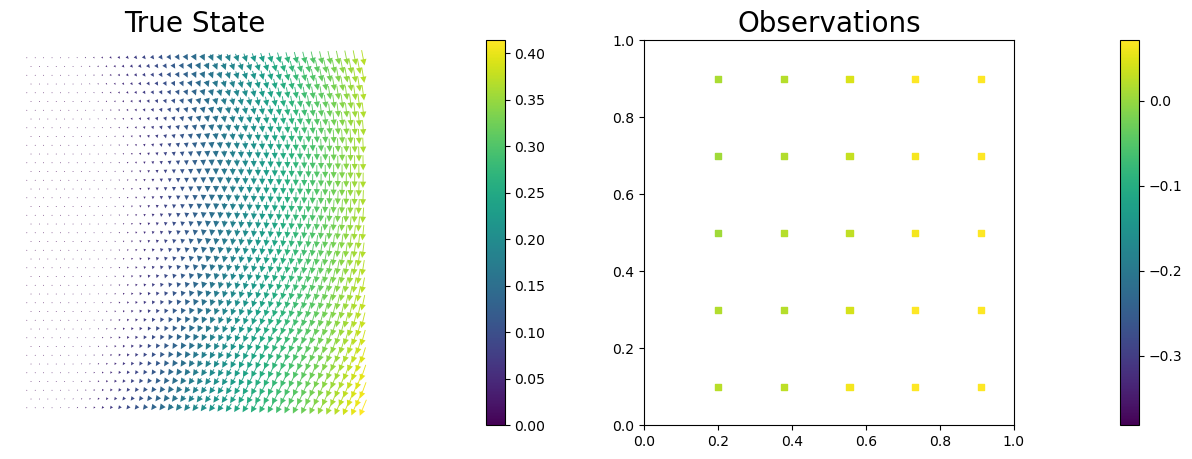

In [4]:
rel_noise = 0.01

utrue = model.problem.generate_state()
x = [utrue, mtrue, None]
model.problem.solveFwd(x[STATE], x)

model.misfit.B.mult(x[STATE], model.misfit.d)

MAX = model.misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, model.misfit.d)
model.misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), model.misfit.d.max() )
vmin = min( utrue.min(), model.misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(model.problem.Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
norm = np.linalg.norm(model.misfit.d.get_local().reshape((-1, 2)), axis=1)
tmp = dl.Vector(dl.MPI.comm_world, len(norm))
tmp.set_local(norm)
nb.plot_pts(model.targets, tmp, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)

    
plt.show()

In [5]:
if False:
    m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[hp.PARAMETER])
    _ = hp.modelVerify(model, m0.vector())

## MAP pt estimate with the true model


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.207855e+02    3.205837e+02    2.018087e-01   -1.088701e+04   4.019343e+04   1.000000e+00   5.000000e-01
  2   2    1.548384e+02    1.542431e+02    5.953208e-01   -3.423109e+02   2.110460e+03   1.000000e+00   2.291454e-01
  3   4    8.397726e+01    8.157510e+01    2.402167e+00   -1.635336e+02   9.691414e+02   1.000000e+00   1.552802e-01
  4   1    7.218546e+01    6.976297e+01    2.422489e+00   -2.358779e+01   1.398082e+03   1.000000e+00   1.865043e-01
  5  14    5.541891e+01    4.490011e+01    1.051880e+01   -4.021151e+01   8.782140e+01   1.000000e+00   4.674365e-02
  6   2    5.312035e+01    4.253453e+01    1.058583e+01   -4.446430e+00   4.464858e+02   1.000000e+00   1.053965e-01
  7  12    5.270761e+01    4.267961e+01    1.002800e+01   -8.577714e-01   2.716846e+01   1.000000e+00   2.599890e-02
  8   1    5.270182e+01    4.267433e+01    1.002749e+01   -1.

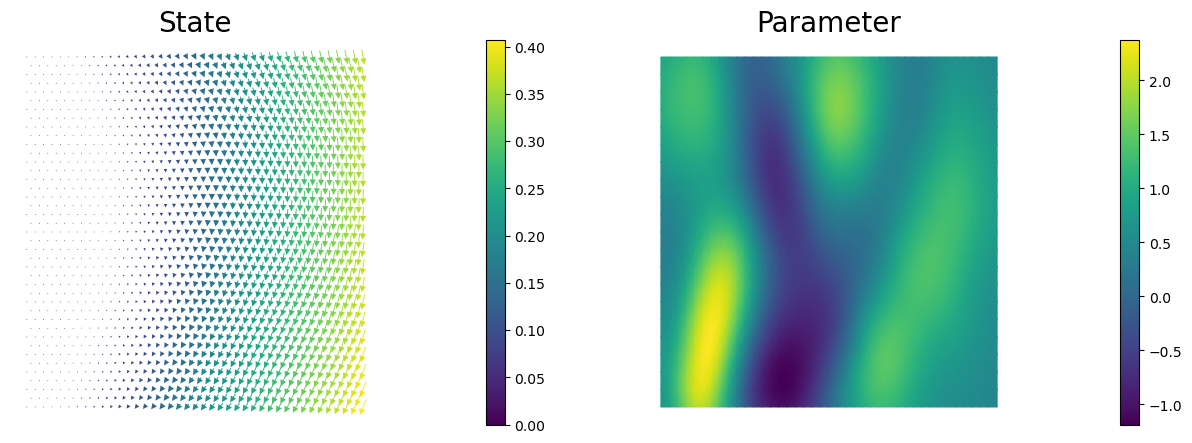

In [6]:
m = model.prior.mean.copy()
solver = hp.ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-8
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 25
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4


x = solver.solve([None, m, None])

if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

## Solve inverse problems with neural operators instead

In [7]:
import torch
import torch.optim as opt
from torch.utils.data import DataLoader

sys.path.append('../../')

from dinotorch_lite import *

from ip_utilities import map_estimate

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

## Load networks, evaluate and make plots

In [8]:
data_dir = 'data/pointwise/'

rM = 100
rQ = 100

mq_data_dict = np.load(data_dir+'mq_data_reduced.npz')
J_data_dict = np.load(data_dir+'JstarPhi_data_reduced.npz')

m_data = mq_data_dict['m_data'][:,:rM]
q_data = mq_data_dict['q_data'][:,:rQ]
J_data = J_data_dict['J_data'][:,:rQ,:rM]
n_data,dQ,dM = J_data.shape

# AS basis was used
os.listdir(data_dir)
AS_basis = np.load(data_dir + 'AS_input_decoder.npy')[:,:rM]
AS_encoder = np.load(data_dir + 'AS_input_encoder.npy')[:,:rM]


m_test = torch.Tensor(m_data[-200:])
q_test = torch.Tensor(q_data[-200:])
J_test = torch.Tensor(J_data[-200:])

l2test = L2Dataset(m_test,q_test)
batch_size = 32

validation_loader = DataLoader(l2test, batch_size=batch_size, shuffle=True)


def load_network(model_name, dM,dQ,device,validation_loader, verbose = False):
    
    network = GenericDense(input_dim = dM,hidden_layer_dim = 2*dM,output_dim = dQ).to(device)
    network.load_state_dict(torch.load(data_dir+model_name))
    rel_error = evaluate_l2_error(network,validation_loader)
    if verbose:
        print(f'Loading {model_name}')
        print(f'Error = {rel_error}')
    return network, rel_error




## Load the networks

In [9]:
n_datas = [25,50,100,200,400,800]
l2_network_names = ['l2_model_'+str(n_data)+'.pth' for n_data in n_datas]
dino_network_names = ['dino_model_'+str(n_data)+'.pth' for n_data in n_datas]

l2_networks = []
l2_errors = []
for name in l2_network_names:
    network,error = load_network(name,dM,dQ,device, validation_loader)
    l2_networks.append(network)
    l2_errors.append(error)
    

dino_networks = []
dino_errors = []
for name in dino_network_names:
    network,error = load_network(name,dM,dQ,device, validation_loader)
    dino_networks.append(network)
    dino_errors.append(error)


    


## Plot $L^2_\mu$ generalization accuracies

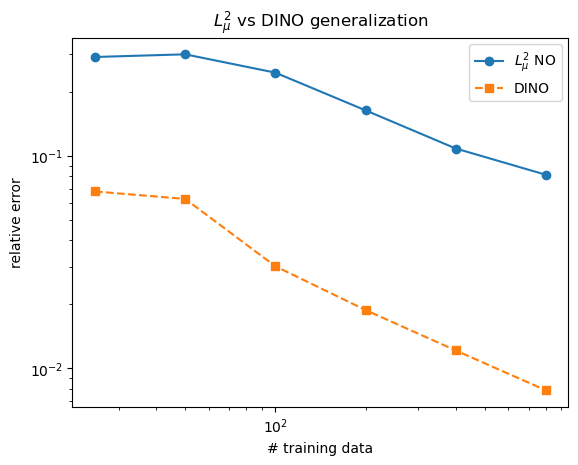

In [10]:
plt.loglog(n_datas, l2_errors, label=r"$L^2_\mu$ NO", linestyle='-', marker='o')
plt.loglog(n_datas,dino_errors, label=r"DINO", linestyle='--', marker='s')
plt.legend()
plt.xlabel("# training data")
plt.ylabel("relative error")
plt.title(r"$L^2_\mu$ vs DINO generalization")
plt.show()

## Vizualize IP solutions

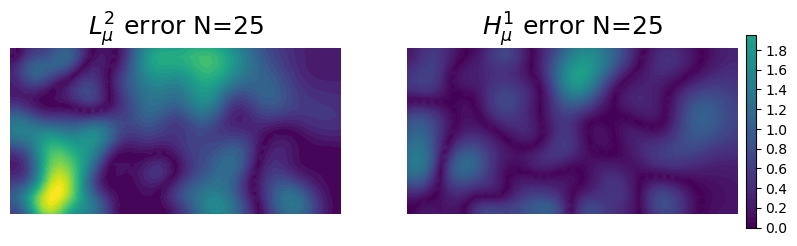

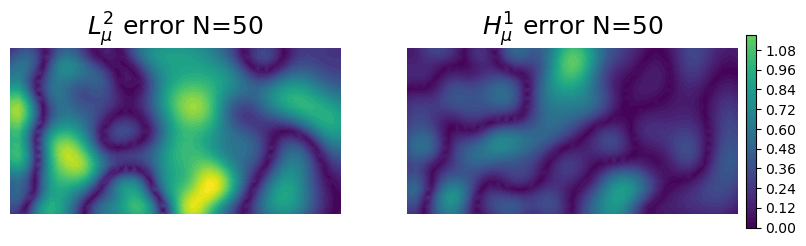

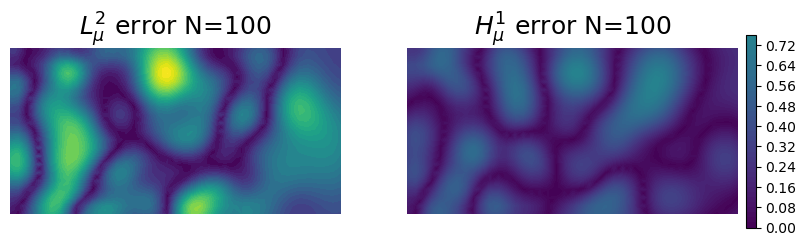

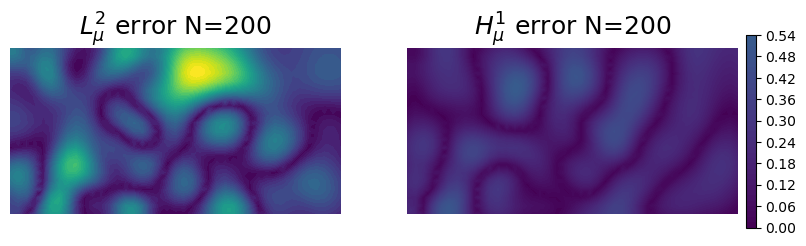

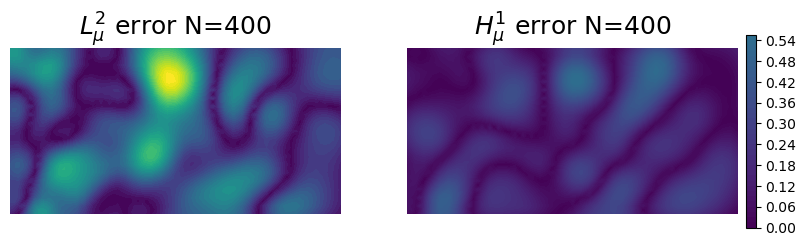

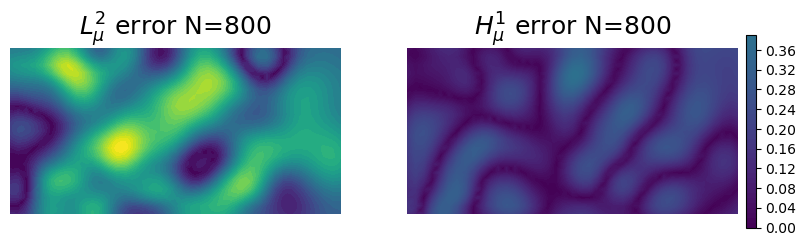

In [11]:

l2_ip_errors = []
dino_ip_errors = []
m_r = AS_encoder.T@model.prior.mean

for n_data, l2_model, dino_model in zip(n_datas,l2_networks,dino_networks):
    l2_map = map_estimate(l2_model, m_r, model, iterations = 100,verbose=False)
    l2m_MAP = AS_basis@l2_map
    dino_map = map_estimate(dino_model, m_r, model, iterations = 100,verbose=False)
    dinom_MAP = AS_basis@dino_map
    
    l2_map = dl.Function(Vh[hp.PARAMETER])
    dino_map = dl.Function(Vh[hp.PARAMETER])
    true_map = dl.Function(Vh[hp.PARAMETER],x[hp.PARAMETER])
    
    l2_error = dl.Function(Vh[hp.PARAMETER])
    dino_error = dl.Function(Vh[hp.PARAMETER])
    l2_error.vector().set_local(np.abs(l2m_MAP - true_map.vector().get_local()))
    dino_error.vector().set_local(np.abs(dinom_MAP - true_map.vector().get_local()))

    l2_ip_errors.append(dl.norm(l2_error)/dl.norm(true_map))
    dino_ip_errors.append(dl.norm(dino_error)/dl.norm(true_map))
    
    ip_sols = [l2_error,dino_error]
    titles = [r"$L^2_\mu$ error N="+str(n_data),r"$H^1_\mu$ error N="+str(n_data)]
    ip_solution_plot(ip_sols,titles)

## Plot IP errors

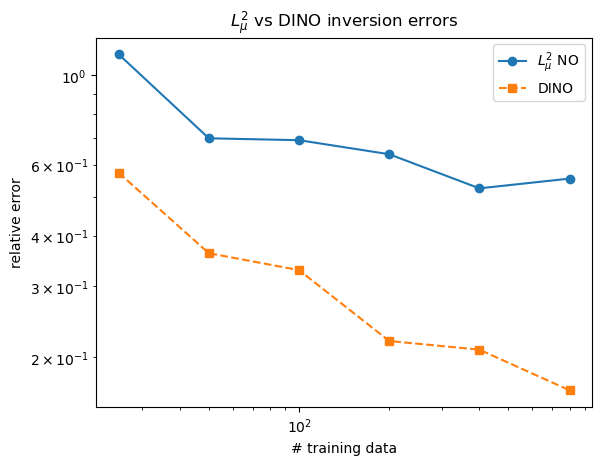

In [12]:
plt.loglog(n_datas, l2_ip_errors, label=r"$L^2_\mu$ NO", linestyle='-', marker='o')
plt.loglog(n_datas,dino_ip_errors, label=r"DINO", linestyle='--', marker='s')
plt.legend()
plt.xlabel("# training data")
plt.ylabel("relative error")
plt.title(r"$L^2_\mu$ vs DINO inversion errors")
plt.show()